# Dependencies

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers[torch]

Ignore colab import if running locally

In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Replace `csv` with the path to any file in the `data` directory with format `{ticker_name}/stock_with_sentiment.csv`

In [151]:
import pandas as pd
csv = "/content/drive/My Drive/WPI/Senior Year/CS539 (ML)/AAPL_stock_with_sentiment.csv"
df = pd.read_csv(csv)
print(len(df))

488


# Create the target labels for each row to indicate whether the stock will have uptrend/downtrend for next day

In [152]:
# get uptrend/downtrend labels for individual stocks
df['Adj Close Next'] = df['Adj Close'].shift(-1)
df['Label'] = df.apply(lambda x: 1 if (x['Adj Close Next'] >= x['Adj Close']) else 0, axis =1)
# check class balancing
print(df['Label'].value_counts())

Label
1    254
0    234
Name: count, dtype: int64


# Preprocess the Data for Training

In [153]:
# seed everything
import numpy as np
seed = 42
np.random.seed(42)

In [154]:
from sklearn.preprocessing import StandardScaler

# Train/Test split = Cannot randomly split for time series data as this would introduce look-ahead bias
num_test_days = int(len(df)*0.2)
dates = df['Date'].unique()
split = len(dates) - num_test_days
train_dates = dates[:split]
test_dates = dates[split:]

train_df = df[df['Date'].isin(train_dates)]
test_df = df[df['Date'].isin(test_dates)]

print(train_df['Label'].value_counts(),
      test_df['Label'].value_counts())

# Create target data set
y_train = np.array(train_df['Label'])
y_test = np.array(test_df['Label'])

stock_features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# only include relevant features
continuous_features = ['mean_neg_sentiment_prob', 'mean_neu_sentiment_prob', 'mean_pos_sentiment_prob']

# continuous_features += ['sma50', 'sma21', 'ema50', 'ema21', 'lag_1', 'lag_3', 'lag_5', 'pct_change', 'vol_pct_change']

count_features = ['neg_sentiment_cnt', 'neu_sentiment_cnt', 'pos_sentiment_cnt']

# Create baseline features without sentiment
X_train_b = train_df[stock_features]
X_test_b = test_df[stock_features]

# Create features with sentiment
X_train = train_df[stock_features + continuous_features + count_features]
X_test = test_df[stock_features + continuous_features + count_features]

print(X_train.columns)

# Assuming X_train_continuous and X_test_continuous are correctly defined somewhere in your code:
scaler = StandardScaler()

X_train_b = scaler.fit_transform(X_train_b)
X_test_b = scaler.transform(X_test_b)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Label
1    198
0    193
Name: count, dtype: int64 Label
1    56
0    41
Name: count, dtype: int64
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'mean_neg_sentiment_prob', 'mean_neu_sentiment_prob',
       'mean_pos_sentiment_prob', 'neg_sentiment_cnt', 'neu_sentiment_cnt',
       'pos_sentiment_cnt'],
      dtype='object')


# Training Models
RandomSearch is used here to tune model hyperparameters.

In [165]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, make_scorer


def train(model, X_train, y_train, best_params, seed):
    """
    Trains models on pre-determined tuned params
    Returns the best estimator
    """
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    return model


def test(model, X_test, y_test):
    """
    Tests model
    Prints classification report and confusion matrix
    """
    # Final Classification Report
    y_pred = model.predict(X_test)
    # y_probs = model.predict_proba(X_test)
    # print(y_probs)
    labels = ['Downtrend', 'Uptrend']

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=labels))
    print(f"Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}")
    print(f"MCC Score: {matthews_corrcoef(y_true=y_test, y_pred=y_pred)}")

    # confusion matrix
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    disp.plot()
    plt.show()

Result for baseline (no sentiment features):
              precision    recall  f1-score   support

   Downtrend       0.46      0.90      0.61        41
     Uptrend       0.76      0.23      0.36        56

    accuracy                           0.52        97
   macro avg       0.61      0.57      0.48        97
weighted avg       0.64      0.52      0.46        97

Accuracy: 0.5154639175257731
MCC Score: 0.17486507696634918


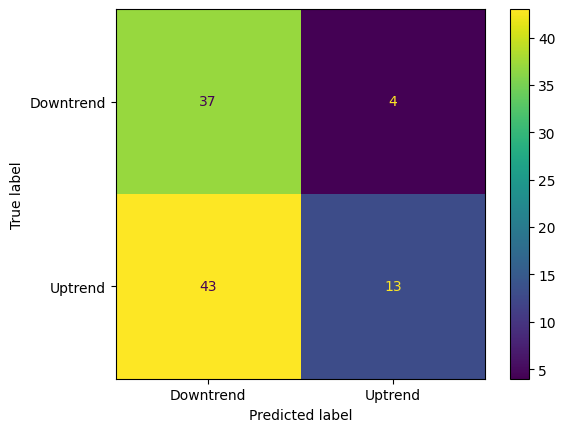

Result with sentiment features:
              precision    recall  f1-score   support

   Downtrend       0.55      0.41      0.47        41
     Uptrend       0.64      0.75      0.69        56

    accuracy                           0.61        97
   macro avg       0.59      0.58      0.58        97
weighted avg       0.60      0.61      0.60        97

Accuracy: 0.6082474226804123
MCC Score: 0.17440263540470408


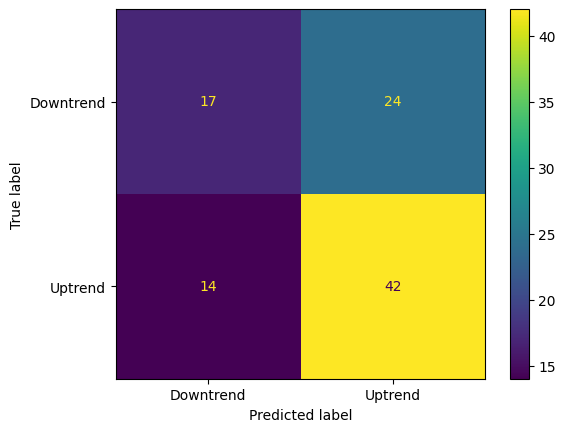

In [166]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=seed)

# best params obtained from RandomizedSearchCV
best_params = {
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': 8,
    'max_features': 'log2',
    'min_samples_leaf': 14,
    'min_samples_split': 18,
    'splitter': 'random'
}

print(f"Result for baseline (no sentiment features):")
best_estimator_b = train(model, X_train_b, y_train, best_params, seed)
test(best_estimator_b, X_test_b, y_test)

print(f"Result with sentiment features:")
best_estimator = train(model, X_train, y_train, best_params, seed)
test(best_estimator, X_test, y_test)

# Test Influence of News Sentiment on Tomorrow's Trend for AAPL

Load tokenizer and Sentiment model

In [157]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model_s = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

Create a dummy test sample with only stock features

In [158]:
# create dummy test sample
X_dummy = test_df[stock_features].sample(n=1, random_state=100)
print(X_dummy)

     Adj Close   Close    High     Low   Open    Volume
473    195.461  195.71  195.99  193.67  194.2  53377300


Test Positive, Neutral, and Negative Dummy News

In [178]:
pos_articles = ['AAPL stock price is increasing',
                'AAPL stock is doing well today',
                'AAPL stock is very bullish today']

neu_articles = ['AAPL stock is the same',
                'AAPL stock has not changed',
                'AAPL stock price has not seen any change recently']

neg_articles = ['Quarterly profit is worse',
                'AAPL stock price is decreasing',
                'AAPL stock is plummeting and doing terribly!']

all_articles = {
    "pos": pos_articles,
    "neu": neu_articles,
    "neg": neg_articles,
}

In [179]:
dfs = {}
for k, articles in all_articles.items():
    sentiment_scores = []
    sentiment_probs = []
    for text in articles:
        # Perform sentiment analysis
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model_s(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        score = probs.argmax(dim=-1).item()
        probs = probs.detach().cpu().numpy().tolist()
        sentiment_scores.append(score)
        sentiment_probs.append(probs)
    s_df = pd.DataFrame()
    s_df['sentiment_score'] = sentiment_scores
    s_df['sentiment_probs'] = sentiment_probs
    dfs[k] = s_df

Generate sentiment features

In [161]:
import numpy as np

score_map = {
    0: 'neg',
    1: 'neu',
    2: 'pos',
}

def generate_sentiment_cnt_features(sentiment_df):
    # count the number of neutral, pos, neg, articles per day
    cnt = sentiment_df['sentiment_score'].value_counts()
    for idx, s_val in score_map.items():
        if idx in cnt:
            s_cnt = cnt[idx]
        else:
            s_cnt = 0
        sentiment_df[f'{s_val}_sentiment_cnt'] = s_cnt
    sentiment_cnt = sentiment_df[['neg_sentiment_cnt',
                                  'neu_sentiment_cnt',
                                  'pos_sentiment_cnt']].drop_duplicates()
    return sentiment_cnt

def generate_sentiment_prob_features(sentiment_df):
    # print(sentiment_df[['neg_sentiment_prob', 'neu_sentiment_prob', 'pos_sentiment_prob']])
    rename_map ={
        'neg_sentiment_prob': 'mean_neg_sentiment_prob',
        'neu_sentiment_prob': 'mean_neu_sentiment_prob',
        'pos_sentiment_prob': 'mean_pos_sentiment_prob',
    }
    # compute average neutral, pos, neg probs across all articles
    mean_probs = sentiment_df[['neg_sentiment_prob', 'neu_sentiment_prob', 'pos_sentiment_prob']].mean()
    for s_val, mean in mean_probs.items():
        colname = rename_map[s_val]
        sentiment_df[colname] = mean
    sentiment_mean_probs = sentiment_df[['mean_neg_sentiment_prob',
                              'mean_neu_sentiment_prob',
                              'mean_pos_sentiment_prob']].drop_duplicates()
    return sentiment_mean_probs

def generate_sentiment_features(sentiment_df):
    sentiment_df['neg_sentiment_prob'] = sentiment_df['sentiment_probs'].apply(
        lambda x: float(x[0][0])
    )
    sentiment_df['neu_sentiment_prob'] = sentiment_df['sentiment_probs'].apply(
        lambda x: float(x[0][1])
    )
    sentiment_df['pos_sentiment_prob'] = sentiment_df['sentiment_probs'].apply(
        lambda x: float(x[0][2])
    )
    daily_sentiment_cnt = generate_sentiment_cnt_features(sentiment_df)
    daily_sentiment_mean_probs = generate_sentiment_prob_features(sentiment_df)

    # print(daily_sentiment_mean_probs)
    daily_sentiment_features = daily_sentiment_mean_probs.join(daily_sentiment_cnt)
    return daily_sentiment_features

In [190]:
name_map = {
    'neg': 'negative',
    'neu': 'neutral',
    'pos': 'positive',
}

print("How different sentiments affect trend prediction for same set of stock features\n\n")
print(f"Stock features:\n{X_dummy}\n\n")

for k, sdf in dfs.items():
    print(f"Mostly {name_map[k]} news:")
    sentiment_df = generate_sentiment_features(sdf).reset_index().drop(columns=['index'])
    X_t = X_dummy.reset_index().drop(columns=['index']).join(sentiment_df)
    # print(X_t)
    X_t = scaler.transform(X_t)
    probs = best_estimator.predict_proba(X_t)
    print(f"Probability for Downtrend: {(probs[0][0] * 100):0.2f}%")
    print(f"Probability for Uptrend: {(probs[0][1] * 100):0.2f}%\n")

How different sentiments affect trend prediction for same set of stock features


Stock features:
     Adj Close   Close    High     Low   Open    Volume
473    195.461  195.71  195.99  193.67  194.2  53377300


Mostly positive news:
Probability for Downtrend: 59.26%
Probability for Uptrend: 40.74%

Mostly neutral news:
Probability for Downtrend: 33.33%
Probability for Uptrend: 66.67%

Mostly negative news:
Probability for Downtrend: 40.00%
Probability for Uptrend: 60.00%

